<a href="https://colab.research.google.com/github/chandhru17/Alzheimers-disease-detection/blob/main/CNN_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [ ]:
from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset
License(s): GNU Lesser General Public License 3.0
100% 379M/380M [00:18<00:00, 24.3MB/s]
100% 380M/380M [00:18<00:00, 21.5MB/s]


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile('/content/augmented-alzheimer-mri-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
#Parameters

img_height = 200
img_width = 190

In [ ]:
#Loading dataset
validation_split = 0.2
batch_size = 32

train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/AugmentedAlzheimerDataset',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=validation_split,
    subset='training',
    seed = 123
)

val_ds = keras.utils.image_dataset_from_directory(
    directory='/content/AugmentedAlzheimerDataset',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=validation_split,
    subset='validation',
    seed = 123
)

Found 33984 files belonging to 4 classes.
Using 27188 files for training.
Found 33984 files belonging to 4 classes.
Using 6796 files for validation.


In [ ]:
#CNN model
model = tf.keras.Sequential([
    layers.Conv2D(32, (7, 7), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (7, 7), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (7, 7), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (7, 7), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(512, (7, 7), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Flatten() #Removed dropout layer
])

In [ ]:
# Extracting features from model
train_features = []
train_labels = []
num_processed_train_images = 0

print("Starting feature extraction phase...")
for image_batch, label_batch in train_ds:
    features = model.predict(image_batch)
    train_features.extend(features)
    train_labels.extend(label_batch.numpy())
    num_processed_train_images += len(image_batch)
print("Completed feature extraction phase")

train_features = np.array(train_features)
train_labels = np.array(train_labels)

Starting feature extraction phase...
1/1 [==============================] - 1s 1s/step
Completed feature extraction phase


In [ ]:
#SVM
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(train_features, train_labels)

val_features = []
val_labels = []
num_processed_val_images = 0

print("Starting testing extraction phase...")
for image_batch, label_batch in val_ds:
    features = model.predict(image_batch)
    val_features.extend(features)
    val_labels.extend(label_batch.numpy())
    num_processed_val_images += len(image_batch)
print("Completed testing extraction phase...")

val_features = np.array(val_features)
val_labels = np.array(val_labels)

val_features = scaler.transform(val_features)

val_predictions = svm_classifier.predict(val_features)

In [ ]:
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
accuracy = svm_classifier.score(val_features, val_labels)
print("Validation Accuracy:", round(accuracy * 100, 2), "%\n")

report = classification_report(val_labels, val_predictions, target_names = class_names)
print("Classification Report:\n", report)

Validation Accuracy: 70.0 %

Classification Report:
                   precision    recall  f1-score   support

    MildDemented       0.62      0.78      0.69      1801
ModerateDemented       0.91      0.88      0.90      1319
     NonDemented       0.73      0.67      0.70      1942
VeryMildDemented       0.60      0.51      0.55      1734

        accuracy                           0.70      6796
       macro avg       0.72      0.71      0.71      6796
    weighted avg       0.70      0.70      0.70      6796



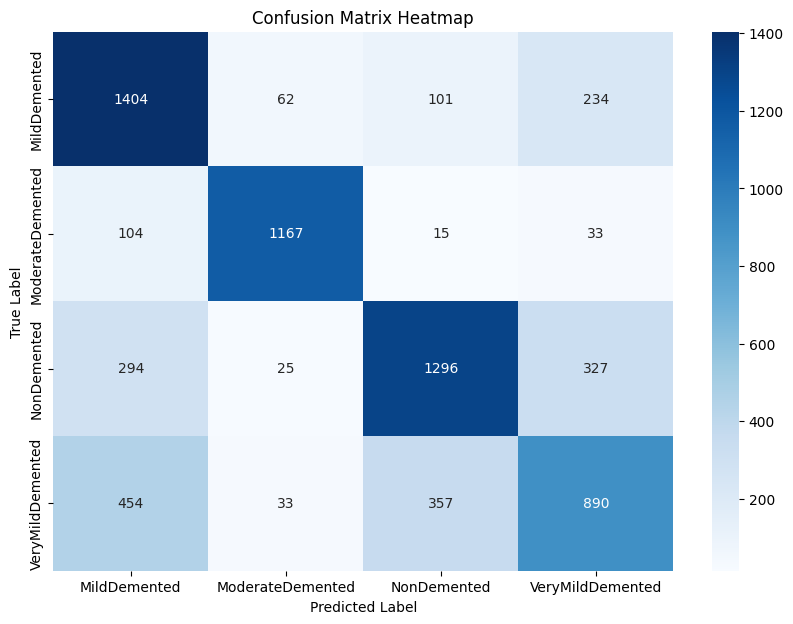

In [ ]:
conf_matrix = confusion_matrix(val_labels, val_predictions)

plt.figure(figsize=(10, 7))
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()